https://realpython.com/linear-regression-in-python/

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
import mplfinance as mpf
from statsmodels.tsa.api import SimpleExpSmoothing

import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from src import tests_utils as u

## Get the data

In [2]:
df = pd.read_csv('../../data/binance_BTCUSDT_1h_from_2020_01_01_to_2022_09_30_candlesticks_signals_raw.csv')

In [3]:
df.index = pd.DatetimeIndex(df['formatted_open_time'])

In [4]:
df.columns.values

array(['open_time', 'open', 'high', 'low', 'close', 'volume',
       'close_time', 'quote_asset_volumne', 'number_of_trades',
       'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume',
       'ignore', 'formatted_open_time', 'formatted_close_time',
       'upper_shadow', 'lower_shadow', 'real_body', 'CDLINVERTEDHAMMER',
       'CDLHAMMER', 'CDLPIERCING', 'CDLMORNINGSTAR', 'CDLSHOOTINGSTAR',
       'CDLHANGINGMAN', 'CDLDARKCLOUDCOVER', 'CDLEVENINGSTAR',
       'CDLENGULFING', 'CDLENGULFINGBULLISH', 'CDLENGULFINGBEARISH'],
      dtype=object)

## Select a particular candlestick patterns type to analyse

In [5]:
#df[df['CDLINVERTEDHAMMER'] == 100]
df[df['CDLSHOOTINGSTAR'] == -100]

,open_time,open,high,low,close,volume,close_time,quote_asset_volumne,number_of_trades,taker_buy_base_asset_volume,...,CDLHAMMER,CDLPIERCING,CDLMORNINGSTAR,CDLSHOOTINGSTAR,CDLHANGINGMAN,CDLDARKCLOUDCOVER,CDLEVENINGSTAR,CDLENGULFING,CDLENGULFINGBULLISH,CDLENGULFINGBEARISH
formatted_open_time,,,,,,,,,,,,,,,,,,,,,
2020-01-07 19:00:00,1578423600000,8038.54,8111.45,8032.39,8073.69,4283.208684,1578427199999,3.459534e+07,33612,2191.476013,...,0,0,0,-100,0,0,0,0,0,0
2020-01-08 11:00:00,1578481200000,8327.06,8370.00,8325.03,8332.47,2034.529797,1578484799999,1.698411e+07,17716,877.142519,...,0,0,0,-100,0,0,0,0,0,0
2020-01-12 19:00:00,1578855600000,8119.91,8160.42,8119.32,8132.01,1572.616110,1578859199999,1.280281e+07,12225,627.697042,...,0,0,0,-100,0,0,0,0,0,0
2020-01-21 21:00:00,1579640400000,8719.98,8789.00,8716.67,8729.98,4252.601207,1579643999999,3.721471e+07,28471,2404.041416,...,0,0,0,-100,0,0,0,0,0,0
2020-01-24 18:00:00,1579888800000,8472.85,8503.72,8469.70,8485.75,1035.121808,1579892399999,8.784324e+06,12647,562.477305,...,0,0,0,-100,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-11 11:00:00,1660215600000,24479.06,24685.20,24462.98,24559.37,8048.802570,1660219199999,1.977010e+08,315979,4109.053240,...,0,0,0,-100,0,0,0,0,0,0
2022-08-17 03:00:00,1660705200000,23992.62,24085.00,23988.33,24006.66,5865.133050,1660708799999,1.410013e+08,216517,2947.810490,...,0,0,0,-100,0,0,0,0,0,0
2022-09-17 01:00:00,1663376400000,19949.72,20059.00,19945.52,20000.39,9250.706040,1663379999999,1.850520e+08,170239,4628.117650,...,0,0,0,-100,0,0,0,0,0,0


## Given the candlestick pattern, select one event in particular

In [6]:
event_date = '2020-01-24 18:00:00'

In [7]:
idx = df.index.get_loc(event_date)

In [8]:
# time_window = 12 #5m (last hour)
# time_window = 12 #15m (last 3 hours)
# time_window = 12 #1h (half day)
# time_window = 12 #1d (~ two weeks)
time_window = 12

In [9]:
df_temp = df.iloc[idx - time_window :idx + 1]
df_temp

,open_time,open,high,low,close,volume,close_time,quote_asset_volumne,number_of_trades,taker_buy_base_asset_volume,...,CDLHAMMER,CDLPIERCING,CDLMORNINGSTAR,CDLSHOOTINGSTAR,CDLHANGINGMAN,CDLDARKCLOUDCOVER,CDLEVENINGSTAR,CDLENGULFING,CDLENGULFINGBULLISH,CDLENGULFINGBEARISH
formatted_open_time,,,,,,,,,,,,,,,,,,,,,
2020-01-24 06:00:00,1579845600000,8320.94,8350.00,8318.76,8345.66,779.822099,1579849199999,6.500693e+06,9752,433.606897,...,0,0,0,0,0,0,0,0,0,0
2020-01-24 07:00:00,1579849200000,8346.03,8353.91,8307.50,8340.00,1163.576236,1579852799999,9.689750e+06,11702,580.250801,...,0,0,0,0,0,0,0,0,0,0
2020-01-24 08:00:00,1579852800000,8338.53,8346.22,8315.95,8332.51,1152.413715,1579856399999,9.599119e+06,12312,552.152746,...,0,0,0,0,0,0,0,0,0,0
2020-01-24 09:00:00,1579856400000,8332.56,8338.95,8260.19,8260.23,2534.582950,1579859999999,2.101843e+07,24837,1221.619246,...,0,0,0,0,0,0,0,0,0,0
2020-01-24 10:00:00,1579860000000,8260.20,8313.00,8238.99,8245.47,2352.899190,1579863599999,1.946274e+07,18545,1061.653218,...,0,0,0,0,0,0,0,0,0,0
2020-01-24 11:00:00,1579863600000,8245.45,8418.00,8238.00,8412.77,5247.520244,1579867199999,4.381975e+07,40537,2811.116049,...,0,0,100,0,0,0,0,100,100,0
2020-01-24 12:00:00,1579867200000,8413.42,8459.99,8369.72,8439.10,3454.182112,1579870799999,2.907189e+07,30472,1797.340971,...,0,0,0,0,0,0,0,0,0,0
2020-01-24 13:00:00,1579870800000,8436.53,8480.00,8413.62,8466.27,1936.485916,1579874399999,1.634361e+07,18221,993.142212,...,0,0,0,0,0,0,0,0,0,0
2020-01-24 14:00:00,1579874400000,8466.89,8507.35,8441.56,8468.24,2470.625341,1579877999999,2.094318e+07,22433,1261.642229,...,0,0,0,0,0,0,0,0,0,0


In [10]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13 entries, 2020-01-24 06:00:00 to 2020-01-24 18:00:00
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   open_time                     13 non-null     int64  
 1   open                          13 non-null     float64
 2   high                          13 non-null     float64
 3   low                           13 non-null     float64
 4   close                         13 non-null     float64
 5   volume                        13 non-null     float64
 6   close_time                    13 non-null     int64  
 7   quote_asset_volumne           13 non-null     float64
 8   number_of_trades              13 non-null     int64  
 9   taker_buy_base_asset_volume   13 non-null     float64
 10  taker_buy_quote_asset_volume  13 non-null     float64
 11  ignore                        13 non-null     int64  
 12  formatted_open_time         

## Plot the event range

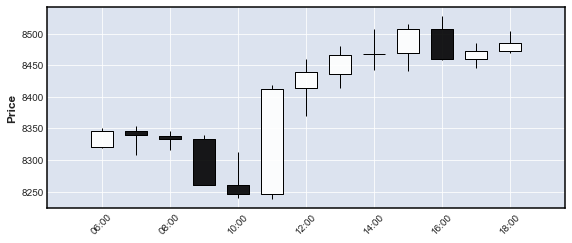

In [11]:
mpf.plot(df_temp, type='candle', figsize=(10,4))

## Do the linear regression of 'left' (multiples slopes of n bars)

### Left

In [12]:
df_slope_all = df_temp #.iloc[:-1] # cut out the reference date
df_slope_all

,open_time,open,high,low,close,volume,close_time,quote_asset_volumne,number_of_trades,taker_buy_base_asset_volume,...,CDLHAMMER,CDLPIERCING,CDLMORNINGSTAR,CDLSHOOTINGSTAR,CDLHANGINGMAN,CDLDARKCLOUDCOVER,CDLEVENINGSTAR,CDLENGULFING,CDLENGULFINGBULLISH,CDLENGULFINGBEARISH
formatted_open_time,,,,,,,,,,,,,,,,,,,,,
2020-01-24 06:00:00,1579845600000,8320.94,8350.00,8318.76,8345.66,779.822099,1579849199999,6.500693e+06,9752,433.606897,...,0,0,0,0,0,0,0,0,0,0
2020-01-24 07:00:00,1579849200000,8346.03,8353.91,8307.50,8340.00,1163.576236,1579852799999,9.689750e+06,11702,580.250801,...,0,0,0,0,0,0,0,0,0,0
2020-01-24 08:00:00,1579852800000,8338.53,8346.22,8315.95,8332.51,1152.413715,1579856399999,9.599119e+06,12312,552.152746,...,0,0,0,0,0,0,0,0,0,0
2020-01-24 09:00:00,1579856400000,8332.56,8338.95,8260.19,8260.23,2534.582950,1579859999999,2.101843e+07,24837,1221.619246,...,0,0,0,0,0,0,0,0,0,0
2020-01-24 10:00:00,1579860000000,8260.20,8313.00,8238.99,8245.47,2352.899190,1579863599999,1.946274e+07,18545,1061.653218,...,0,0,0,0,0,0,0,0,0,0
2020-01-24 11:00:00,1579863600000,8245.45,8418.00,8238.00,8412.77,5247.520244,1579867199999,4.381975e+07,40537,2811.116049,...,0,0,100,0,0,0,0,100,100,0
2020-01-24 12:00:00,1579867200000,8413.42,8459.99,8369.72,8439.10,3454.182112,1579870799999,2.907189e+07,30472,1797.340971,...,0,0,0,0,0,0,0,0,0,0
2020-01-24 13:00:00,1579870800000,8436.53,8480.00,8413.62,8466.27,1936.485916,1579874399999,1.634361e+07,18221,993.142212,...,0,0,0,0,0,0,0,0,0,0
2020-01-24 14:00:00,1579874400000,8466.89,8507.35,8441.56,8468.24,2470.625341,1579877999999,2.094318e+07,22433,1261.642229,...,0,0,0,0,0,0,0,0,0,0


In [13]:
slope_size = 3

In [14]:
list_coeficients = []
list_x = []
list_y = []
list_y_pred = []
for i in range(time_window,slope_size-1,-1): # Loop from 49 to 0 moving in range of -1
    df_slope_temp = df_slope_all[['open_time', 'close']].iloc[i-slope_size:i]
    x = df_slope_temp.open_time.values.reshape((-1,1))
    y = df_slope_temp.close.values
    model = LinearRegression()
    model.fit(x, y)
    list_coeficients.append(model.coef_[0])
    y_pred = model.predict(x)
    

    list_x.append(x)
    list_y.append(y)
    list_y_pred.append(y_pred)
    

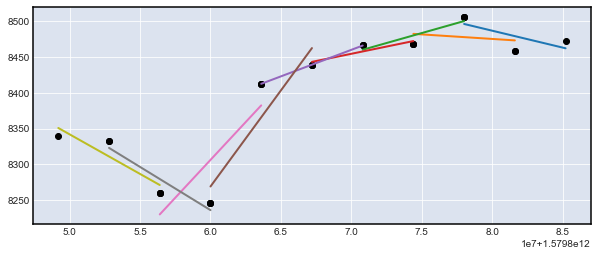

In [15]:
plt.figure(figsize=(10,4))

for i in range(0,time_window-slope_size):
    x = list_x[i]
    y = list_y[i]
    y_pred = list_y_pred[i]

    # plot lines
    plt.scatter(x, y, label = "close price", color="black")
    plt.plot(x, y_pred, label = "regression")

plt.show()

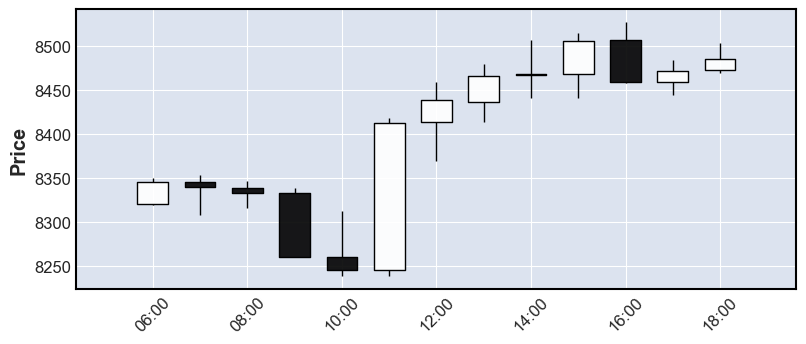

In [16]:
mpf.plot(df_temp, type='candle', figsize=(10,4))

In [17]:
print(list_coeficients)

[-4.726388888888979e-06, -1.2694444444443636e-06, 5.579166666666676e-06, 4.0472222222221415e-06, 7.430555555555554e-06, 2.689305555555569e-05, 2.118611111111123e-05, -1.208888888888901e-05, -1.1079166666666725e-05, -1.8263888888888382e-06]


In [18]:
list = np.array(list_coeficients).reshape(-1,1)
scaler = preprocessing.MaxAbsScaler()
normalizedlist=scaler.fit_transform(list)
list_coeficients_scaled = normalizedlist.reshape(1,-1)[0].tolist()


In [19]:
print(list_coeficients_scaled)

[-0.17574755977896234, -0.047203429220675365, 0.20745752207818965, 0.15049320869699567, 0.27630016009915676, 1.0, 0.7877911480658993, -0.4495171202809504, -0.4119712854413057, -0.0679130300056787]


In [20]:
reverted_list_coeficients = []  # empty list
reverted_list_coeficients_scaled = []

# iterate to reverse the list
for i in list_coeficients:
    # reversing the list
    reverted_list_coeficients.insert(0, i)

# iterate to reverse the list
for i in list_coeficients_scaled:
    # reversing the list
    reverted_list_coeficients_scaled.insert(0, i)


In [21]:
# plt.figure(figsize=(10,4))

# # Plot Graph

# fig, ax1 = plt.subplots()
# ax1.plot(reverted_list_coeficients, label = "list_coeficients", color="red")

# # Twin Axes

# ax2 = ax1.twinx()
# ax2.plot(reverted_list_coeficients_scaled, label = "list_coeficients_scaled", color="orange")

# plt.show()

In [22]:
# sum(list_coeficients_scaled) / len(list_coeficients_scaled)

In [23]:
fit_SES_1 = SimpleExpSmoothing(reverted_list_coeficients, initialization_method="heuristic").fit(
    smoothing_level=0.1, optimized=False)

fit_SES_2 = SimpleExpSmoothing(reverted_list_coeficients, initialization_method="heuristic").fit(
    smoothing_level=0.2, optimized=False)

fit_SES_3 = SimpleExpSmoothing(reverted_list_coeficients, initialization_method="estimated").fit()        

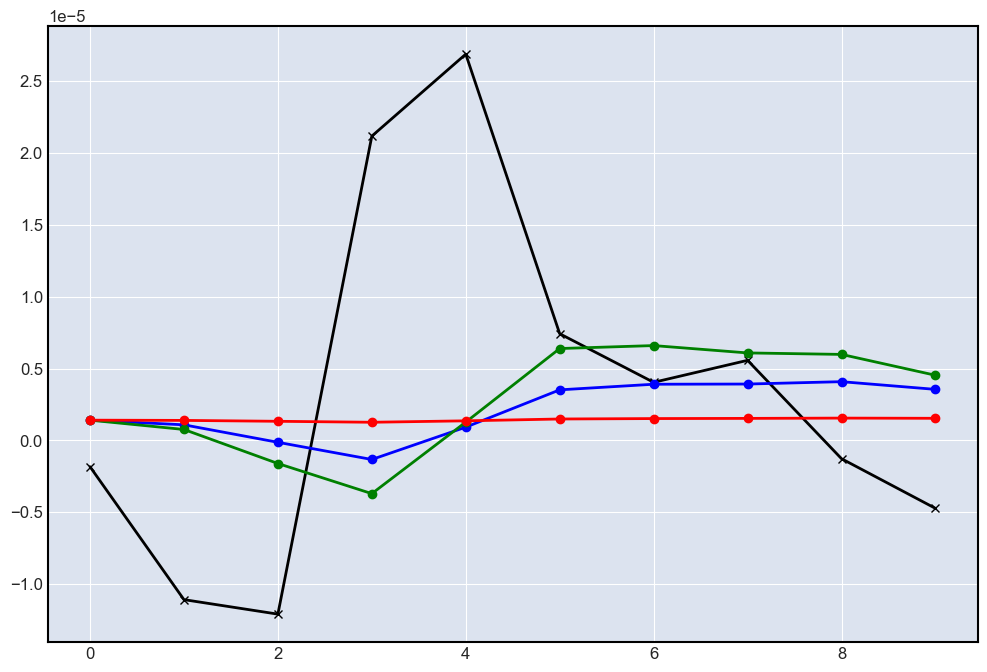

In [24]:
plt.figure(figsize=(12, 8))
plt.plot(reverted_list_coeficients, marker="x", color="black")
plt.plot(fit_SES_1.fittedvalues, marker="o", color="blue")
plt.plot(fit_SES_2.fittedvalues, marker="o", color="green")
plt.plot(fit_SES_3.fittedvalues, marker="o", color="red")


In [25]:
list = np.array(fit_SES_2.fittedvalues.tolist()).reshape(-1,1)
scaler = preprocessing.MaxAbsScaler()
normalizedlist=scaler.fit_transform(list)
list_coeficients_scaled_new = normalizedlist.reshape(1,-1)[0].tolist()


<Figure size 1000x400 with 0 Axes>

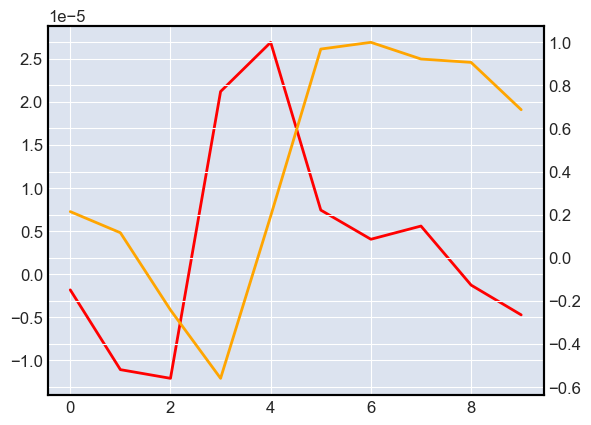

In [26]:
plt.figure(figsize=(10,4))

# Plot Graph

fig, ax1 = plt.subplots()
ax1.plot(reverted_list_coeficients, label = "list_coeficients", color="red")

# Twin Axes

ax2 = ax1.twinx()
ax2.plot(list_coeficients_scaled_new, label = "list_coeficients_scaled_new", color="orange")

plt.show()

In [27]:
sum(list_coeficients_scaled_new) / len(list_coeficients_scaled_new)

0.4205678469169312

In [29]:

intensity_index = u.check_intensity_trend(df, event_date, time_window, slope_size)
print(intensity_index)

0.4205678469169312


In [ ]:
# fit_SES_1 = SimpleExpSmoothing(reverted_list_coeficients_scaled, initialization_method="heuristic").fit(
#     smoothing_level=0.1, optimized=False)

# fit_SES_2 = SimpleExpSmoothing(reverted_list_coeficients_scaled, initialization_method="heuristic").fit(
#     smoothing_level=0.2, optimized=False)

# fit_SES_3 = SimpleExpSmoothing(reverted_list_coeficients_scaled, initialization_method="estimated").fit()        

In [ ]:
# plt.figure(figsize=(12, 8))
# plt.plot(reverted_list_coeficients_scaled, marker="o", color="black")
# plt.plot(fit_SES_1.fittedvalues, marker="o", color="blue")
# plt.plot(fit_SES_2.fittedvalues, marker="o", color="green")
# plt.plot(fit_SES_3.fittedvalues, marker="o", color="red")


In [30]:
print(len(list_coeficients))
pos_count, neg_count = 0, 0
  
# iterating each number in list
for num in list_coeficients:
      
    # checking condition
    if num >= 0:
        pos_count += 1
  
    else:
        neg_count += 1

print("Positive numbers in the list: ", pos_count)
print("Negative numbers in the list: ", neg_count)

10
Positive numbers in the list:  5
Negative numbers in the list:  5


In [31]:
list_coeficients[0]

-4.726388888888979e-06

In [32]:
np.percentile(list_coeficients, 70)

6.134583333333339e-06

In [33]:
#np.percentile(list_coeficients, 70) < list_coeficients[0]
import math

sign_recent_slope_coef = math.copysign(1,list_coeficients[0])
print(sign_recent_slope_coef)

sign_p70_all_slope_coef = math.copysign(1,np.percentile(list_coeficients, 70))
print(sign_p70_all_slope_coef)

sign_recent_slope_coef == sign_p70_all_slope_coef


-1.0
1.0


False

In [34]:
window_size = 12
slope_size = 3

In [ ]:
list_dates_invertedhammer = df[df['CDLINVERTEDHAMMER'] == 100]['formatted_open_time'].to_list()
list_dates_hammer = df[df['CDLHAMMER'] == 100]['formatted_open_time'].to_list()
list_dates_piercing = df[df['CDLPIERCING'] == 100]['formatted_open_time'].to_list()
list_dates_morningstar = df[df['CDLMORNINGSTAR'] == 100]['formatted_open_time'].to_list()

In [ ]:
print(len(list_dates_invertedhammer))
list_validate_dates_invertedhammer = []
for date in list_dates_invertedhammer:
    s = u.check_trend(df, date, window_size, slope_size)
    if ((s==-1)):
        list_validate_dates_invertedhammer.append(date)
print(len(list_validate_dates_invertedhammer))        

In [ ]:
list_dates_invertedhammer[0]

In [ ]:
print(len(list_dates_hammer))
list_validate_dates_hammer = []
for date in list_dates_hammer:
    s = u.check_trend(df, date, window_size, slope_size)
    if ((s==-1)):
        list_validate_dates_hammer.append(date)
print(len(list_validate_dates_hammer))          

In [ ]:
print(len(list_dates_piercing))
list_validate_dates_piercing = []
for date in list_dates_piercing:
    s = u.check_trend(df, date, window_size, slope_size)
    if ((s==-1)):
        list_validate_dates_piercing.append(date)
print(len(list_validate_dates_piercing))        

In [ ]:
print(len(list_dates_morningstar))
list_validate_dates_morningstar = []
for date in list_dates_morningstar:
    s = u.check_trend(df, date, window_size, slope_size)
    if ((s==-1)):
        list_validate_dates_morningstar.append(date)
print(len(list_validate_dates_morningstar))

In [ ]:
list_dates_shootingstar = df[df['CDLSHOOTINGSTAR'] == -100]['formatted_open_time'].to_list()
list_dates_hangingman = df[df['CDLHANGINGMAN'] == -100]['formatted_open_time'].to_list()
list_dates_darkcloudcover = df[df['CDLDARKCLOUDCOVER'] == -100]['formatted_open_time'].to_list()
list_dates_eveningstar = df[df['CDLEVENINGSTAR'] == -100]['formatted_open_time'].to_list()

In [ ]:
print(len(list_dates_shootingstar))
list_validate_dates_shootingstar = []
for date in list_dates_shootingstar:
    s = u.check_trend(df, date, window_size, slope_size)
    if ((s==1)):
        list_validate_dates_shootingstar.append(date)     
print(len(list_validate_dates_shootingstar))        

In [ ]:
list_validate_dates_shootingstar[1]

In [ ]:
print(len(list_dates_hangingman))
list_validate_dates_hangingman = []
for date in list_dates_hangingman:
    s = u.check_trend(df, date, window_size, slope_size)
    if ((s==1)):
        list_validate_dates_hangingman.append(date)
print(len(list_validate_dates_hangingman))        

In [ ]:
print(len(list_dates_darkcloudcover))
list_validate_dates_darkcloudcover = []
for date in list_dates_darkcloudcover:
    s = u.check_trend(df, date, window_size, slope_size)
    if ((s==1)):
        list_validate_dates_darkcloudcover.append(date)
print(len(list_validate_dates_darkcloudcover))        

In [ ]:
print(len(list_dates_eveningstar))
list_validate_dates_eveningstar = []
for date in list_dates_eveningstar:
    s = u.check_trend(df, date, window_size, slope_size)
    if ((s==1)):
        list_validate_dates_eveningstar.append(date)
print(len(list_validate_dates_eveningstar))        